## 1 - Objetivo

A intenção deste exercício é aprender alguns recursos avançados do scikit-learn, especialmente como utilizar *Cross validation*, *Feature Selection* e *Grid Search* para otimizar os hyperparâmetros/features do modelo. Também vamos utilizar este exercício para nos familiarizarmos com as métricas padrão de avaliação de resultados.



## 2 - Carregando as bibliotecas

Mais uma vez vamos utilizar o Scikit-learn. Devido a sua facilidade de utilização e métodos pré-implementados é fácil ver o motivo de ter se tornado padrão na indústria de tecnologia.

Para utilizá-la, vamos primeiro carregar os métodos/módulos necessários

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt  # primeiro importamos a biblioteca para visualização
import numpy as np  # importamos também a biblioteca NumPy que irá nos fornecer diversos métodos para trabalhar com arrays
import seaborn as sns

#### 2.1 - Funções auxiliares

De maneira geral, os algoritmos de machine learning precisam de features numéricas. Por isso, precisamos converter as features que estão em formato textual para um formato mais apropriado. A função abaixo faz isso utilizando uma função pré-implementada pela biblioteca ```pandas```.


In [2]:
def converte_categorias(df):
    pd.options.mode.chained_assignment = None  # default='warn'
    # job
    df.job = pd.Categorical(df.job)
    df['job'] = df.job.cat.codes
    # marital
    df.marital = pd.Categorical(df.marital)
    df['marital'] = df.marital.cat.codes
    # education
    df.education = pd.Categorical(df.education)
    df['education'] = df.education.cat.codes
    # default
    df.default = pd.Categorical(df.default)
    df['default'] = df.default.cat.codes
    # housing
    df.housing = pd.Categorical(df.housing)
    df['housing'] = df.housing.cat.codes
    # loan
    df.loan = pd.Categorical(df.loan)
    df['loan'] = df.loan.cat.codes
    # contact
    df.contact = pd.Categorical(df.contact)
    df['contact'] = df.contact.cat.codes
    # month
    df.month = pd.Categorical(df.month)
    df['month'] = df.month.cat.codes
    # outcome
    df.poutcome = pd.Categorical(df.poutcome)
    df['poutcome'] = df.poutcome.cat.codes
    return df

#### 3 - Dataset

O dataset que vamos utilizar aqui foi disponibilizado para o *UCI Machine Learning repository* por Moro et al., 2014 [1]. Este é um dataset criado para uma campanha de marketing bancário em 2011. Para mais detalhes sobre o dataset, acesse [este link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

*Observação*: O *UCI Machine Learning repository* é o maior repositório de datasets para experimentos com Machine Learning. Ele contém centenas de datasets para download assim como as fontes que os construíram. Desta forma, podemos comparar a performance dos nossos experimentos com a performance obtida pelos criadores do dataset. É um excelente lugar para praticar nossas habilidades com o machine learning.


Abaixo nós utilizamos a biblioteca ```pandas``` para criar um objeto ```DataFrame``` contendo os datapoints.

<sup>[1] S. Moro, P. Cortez and P. Rita. *A Data-Driven Approach to Predict the Success of Bank Telemarketing*. Decision Support Systems, Elsevier, 62:22-31, June 2014</sup>

In [3]:
trainset = pd.read_csv("data/trainset.csv")
testset = pd.read_csv("data/testset.csv")

X_train = trainset.loc[:, trainset.columns != "y"]
y_train = trainset.loc[:, trainset.columns == "y"]
y_train = y_train.values.ravel()


X_test = testset.loc[:, testset.columns != "y"]
y_test = testset.loc[:, testset.columns == "y"]
y_test = y_test.values.ravel()

trainset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,44,JobCat9,single,secondary,no,29,yes,no,unknown,5,may,0,1,-1,0,unknown,TypeA
1,47,JobCat3,married,unknown,no,1506,yes,no,unknown,5,may,0,1,-1,0,unknown,TypeA
2,31,unknown,single,unknown,no,1,no,no,unknown,5,may,0,1,-1,0,unknown,TypeA
3,26,JobCat6,single,tertiary,no,447,yes,yes,unknown,5,may,0,1,-1,0,unknown,TypeA
4,42,JobCat4,divorced,tertiary,yes,2,yes,no,unknown,5,may,0,1,-1,0,unknown,TypeA
5,58,JobCat2,married,primary,no,121,yes,no,unknown,5,may,0,1,-1,0,unknown,TypeA
6,41,JobCat11,divorced,secondary,no,270,yes,no,unknown,5,may,0,1,-1,0,unknown,TypeA
7,58,JobCat9,married,unknown,no,71,yes,no,unknown,5,may,0,1,-1,0,unknown,TypeA
8,51,JobCat2,married,primary,no,229,yes,no,unknown,5,may,0,1,-1,0,unknown,TypeA
9,45,JobCat11,single,unknown,no,13,yes,no,unknown,5,may,0,1,-1,0,unknown,TypeA


Devemos sempre visualizar os nossos datapoints para termos uma ideia de com o que estamos lidando. No nosso caso, vamos utilizar uma classe da biblioteca ```seaborn``` para criar os gráficos. Entretanto, na maioria dos casos o tamanho do dataset torna proibitivo o uso de algumas funções auxiliares das bibliotecas de visualização e devemos criar os gráficos de forma independente.

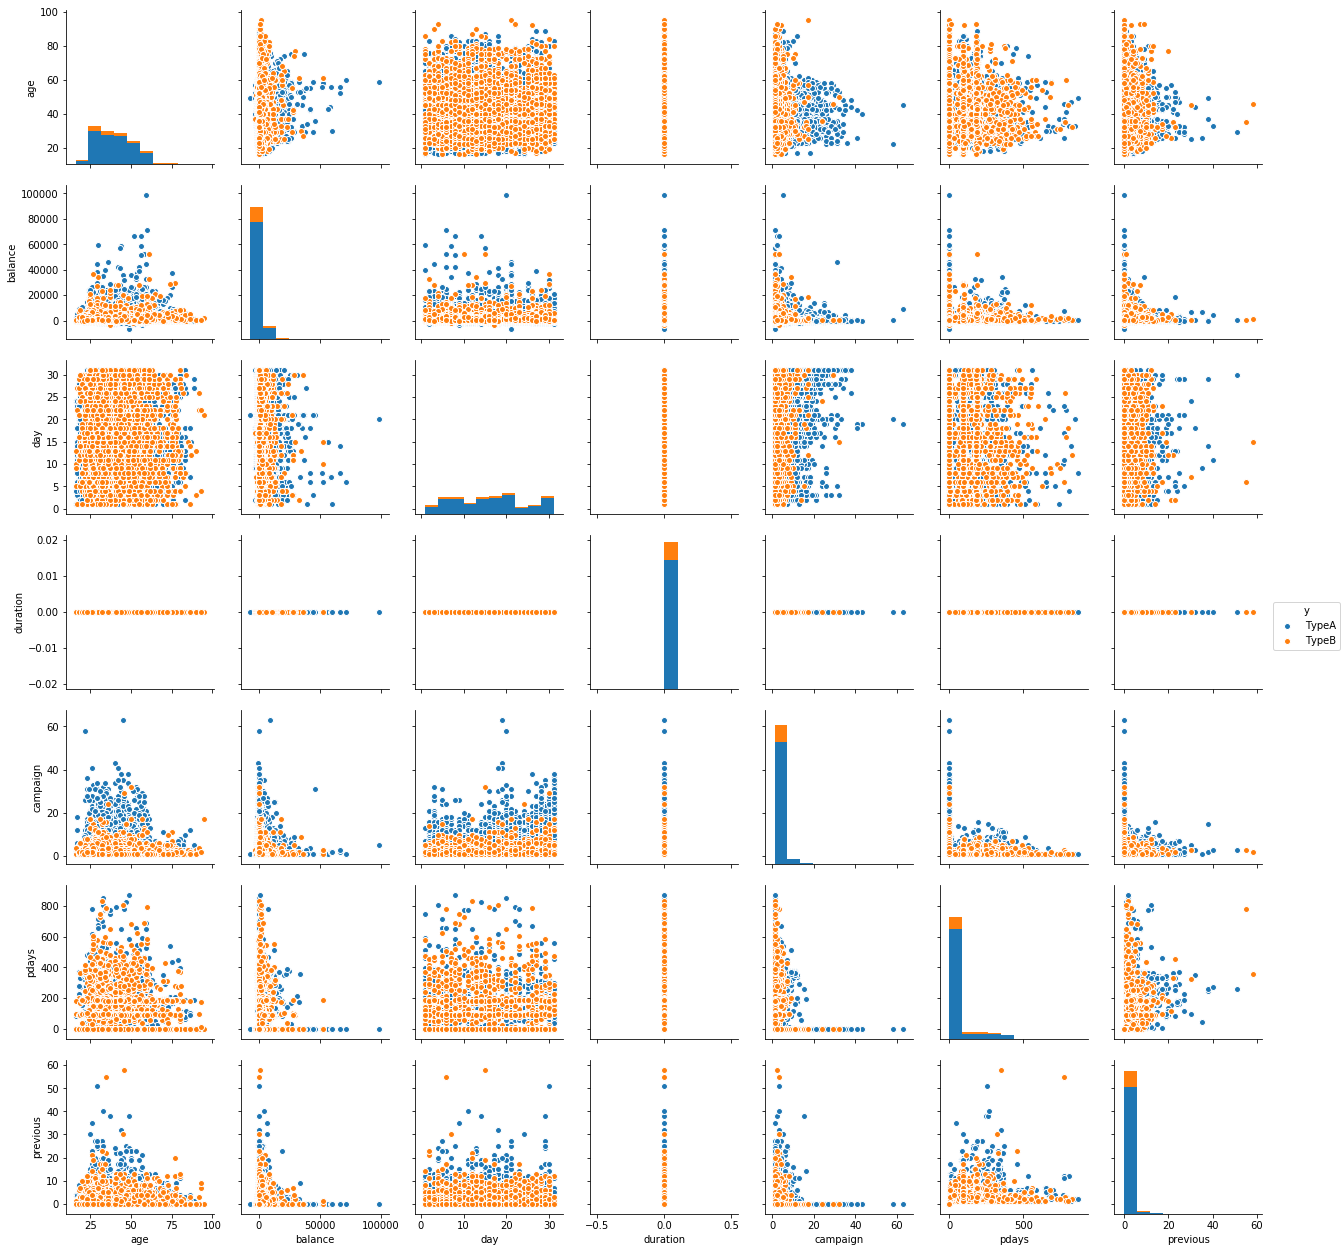

In [4]:
sns.pairplot(trainset, hue="y")  # o parametro 'hue' diz qual coluna contém o alvo para distribuir as cores


#### 3.1 - Convertendo as features

Como mencionado anteriormente, alguns algoritmos de machine learning precisam que as features estejam em formato numérico. Abaixo utilizamos a função que criamos no início do exercício para realizar a conversão.

In [5]:
X_train = converte_categorias(X_train)
X_test = converte_categorias(X_test)
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,44,10,2,1,0,29,1,0,2,5,8,0,1,-1,0,3
1,47,4,1,3,0,1506,1,0,2,5,8,0,1,-1,0,3
2,31,11,2,3,0,1,0,0,2,5,8,0,1,-1,0,3
3,26,7,2,2,0,447,1,1,2,5,8,0,1,-1,0,3
4,42,5,0,2,1,2,1,0,2,5,8,0,1,-1,0,3
5,58,3,1,0,0,121,1,0,2,5,8,0,1,-1,0,3
6,41,2,0,1,0,270,1,0,2,5,8,0,1,-1,0,3
7,58,10,1,3,0,71,1,0,2,5,8,0,1,-1,0,3
8,51,3,1,0,0,229,1,0,2,5,8,0,1,-1,0,3
9,45,2,2,3,0,13,1,0,2,5,8,0,1,-1,0,3


### 4 - Experimentos

Feita a conversão das features é hora de realizarmos nossos experimentos.

#### 4.1 - Carregando as bibliotecas necessárias

Como mencionado anteriormente, o ScikitLearn possui diversas funções auxiliares para realizarmos experimentos e encontrar o melhor modelo para uma determinada tarefa. Abaixo nós importaremos as funções relevantes e um algoritmo para realizarmos experimentos.


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

#### 4.2 - Buscando os melhores hyperparâmetros 

Agora que as funções estão carregadas, vamos testá-las e gerar o melhor resultado possível para nossa tarefa. 


In [36]:
folds = 3  # precisa ser maior que 2

# aqui nós criamos um objeto dicionário com o nome do hyperparâmetro e os possíveis valores que ele pode assumir
# os hyperparâmetros são específicos para cada algoritmo! Note como neste caso nós chamamos a classe do algoritmo
# sem passarmos os hyperparâmetros default
knn = KNeighborsClassifier()
knn_params = {
    "n_neighbors": [2, 3, 5, 10],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}



# O scikit learn e uma biblioteca bastante flexível. Com poucas linhas de código, podemos executar o mesmo experimento
# para diversos algoritmos: basta criar uma lista contendo os algoritmos e uma segunda lista contendo os 
# dicionários de hyperparâmetros. Detalhe: a ordem das listas é importante!
classifiers = [knn]
grids = [knn_params]

# gera uma lista de tuplas entre classifiers e grids para que cada um fique na
# posição correta [(class.1, parms.1), (class.2, params.2), ...]
grid_params = zip(classifiers, grids)

# aqui fazemos a busca - neste caso a busca é por força bruta, ou seja, vai
# testar todas as combinações que incluirmos no dicionário de parâmetros - há
# também a opção de se buscar randomicamente, mas precisariamos definir
# distribuições ao invés de parâmetros e os resultados são parecidos.
# a busca vai ser feita pelo ``score'' que definirmos

def select_k_best_features(method,
                           train_features,
                           test_features,
                           targets,
                           k_best=10):
    selector = SelectKBest(method, k=k_best).fit(train_features, targets)
    indices = np.where(selector.get_support() == True)
    new_train_features = selector.transform(train_features)
    new_test_features = selector.transform(test_features)
    return new_train_features, new_test_features, indices


for n in range(1, 17):
    selected_features, selected_test_features, best = select_k_best_features(
            f_classif, X_train, X_test, y_train, k_best=n)
    best_features_names = X_train.columns[best]
    for _, (classifier, params) in enumerate(grid_params):        

        print("Buscando para aloritmo: {0}\n".format(classifier.__class__))

        clf = GridSearchCV(estimator=classifier,  # algoritmo em teste
                                   param_grid=params,  # parâmetros de busca
                                   cv=folds,  # objeto que vai gerar as divisões
                                   n_jobs=-1,
                                   scoring='accuracy')  # score que será utilizado

        clf.fit(X_train, y_train)
        # aqui nós imprimimos o resultado - o método report vai imprimir as ``top''
        # melhores combinações encontrada na busca. Os parâmetros impressos
        # são aqueles que teríamos que usar para gerar o classificador de forma isolada
        print("Melhor seleção de hyperparâmetros:\n")
        print(clf.best_params_)
        print("\nScores (% de acertos) nos folds de validação:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("{:.3f} (+/-{:.3f}) for {}".format(mean, std * 2, params))

        print("\nResultado detalhado para o melhor modelo:\n")
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        
        print(best_features_names)

Buscando para aloritmo: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Melhor seleção de hyperparâmetros:

{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}

Scores (% de acertos) nos folds de validação:

0.810 (+/-0.152) for {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.730 (+/-0.182) for {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.815 (+/-0.154) for {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.737 (+/-0.179) for {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.781 (+/-0.174) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.778 (+/-0.175) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.792 (+/-0.172) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.789 (+/-0.172) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.804 (+/-0.165) for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.801 (+/-0.168) for {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.811 (+/-0.166) for {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.808 (+/-0.168) for {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.828 (+/-0.144) for

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Observe a variação em cada um dos folds do experimento. Esta ocorrência deve-se ao fato de termos um dataset bastante diverso. Isso demonstra a importância de realizarmos o *Cross Validation* para termos uma ideia melhor do comportamento do algoritmo!

### 5 - Exercícios

#### 5.1 - Experimentando com outros algoritmos

Agora que vimos como funciona, vamos experimentar outros algoritmos. Verifique na [documentação do ScikitLearn](http://scikit-learn.org/stable/modules/classes.html) e tente otimizar hyperparâmetros de outros algoritmos. Na célula de código do ítem 4.1 estão algumas sugestões (em forma de comentário) de algoritmos.

Rode experimentos com diferentes algortimos e note como os resultados variam. Note também como alguns algoritmos são mais rápidos para treinar enquanto alguns demoram um pouco mais. Paciência é uma virtude que todo praticante de machine learning deve aprender desde o início!


#### 5.2 - Desafio

Nesta versão da busca por melhores hyperparâmetros nós deixamos de fora a busca pelo melhor conjunto de features. Modifique o código acima baseando-se na explicação [deste link](http://scikit-learn.org/stable/modules/feature_selection.html) usando o código [deste tutorial](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py) e implemente a seleção de features.